# Trader Behavior vs Bitcoin Market Sentiment

## Overview
This project analyzes the relationship between Bitcoin market sentiment
(Fear vs Greed) and trader behavior using historical trading data from
Hyperliquid and the Bitcoin Fear & Greed Index.

The objective is to understand how market psychology impacts trader
profitability, risk-taking behavior, and trade sizing, and to derive
actionable insights that can inform smarter trading strategies.


## Problem Statement
Market sentiment plays a crucial role in financial decision-making.
This analysis explores whether trader performance and behavior differ
significantly during Fear and Greed market conditions.

## Key Questions
- Do traders perform better during Fear or Greed markets?
- How does risk exposure change with market sentiment?
- Are losses or gains more extreme under certain sentiments?
- How can these insights be used to improve trading strategies?


## Dataset Description

### 1. Historical Trader Data (Hyperliquid)
Contains trade-level information such as:
- Trade timestamps
- Profit and loss (Closed PnL)
- Position size and exposure
- Trade direction and size

### 2. Bitcoin Fear & Greed Index
Provides daily market sentiment labels:
- Fear
- Greed

Each trading day is assigned a sentiment classification based on overall
market psychology.


In [9]:
import pandas as pd

# Load datasets
trades_df = pd.read_csv('/content/historical_data.csv')
sentiment_df = pd.read_csv('/content/fear_greed_index.csv')


### Data Loading Summary
Both datasets were successfully loaded into memory. Initial inspection confirms
that the trader dataset contains trade-level execution details, while the sentiment
dataset provides daily Fear and Greed classifications required for downstream analysis.


In [10]:
print("Trades shape:", trades_df.shape)
print("Sentiment shape:", sentiment_df.shape)

trades_df.head(), sentiment_df.head()


Trades shape: (211224, 16)
Sentiment shape: (2644, 4)


(                                      Account  Coin  Execution Price  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
 2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
 3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
 4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   
 
    Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
 0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
 1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
 2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
 3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
 4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   
 
    Closed PnL                                   Transaction Hash     Order ID  \
 0      

### Initial Data Inspection
The structure and schema of both datasets were examined to understand available
features, data types, and missing values. This step helps prevent incorrect
assumptions before performing any data cleaning or transformations.


In [11]:
print(trades_df.columns)
print(sentiment_df.columns)


Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')
Index(['timestamp', 'value', 'classification', 'date'], dtype='object')


In [12]:
# Basic structure
print("=== TRADES DATA INFO ===")
trades_df.info()

print("\n=== SENTIMENT DATA INFO ===")
sentiment_df.info()


=== TRADES DATA INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64


In [13]:
# Column names (important for next steps)
print("Trades columns:")
print(trades_df.columns.tolist())

print("\nSentiment columns:")
print(sentiment_df.columns.tolist())


Trades columns:
['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']

Sentiment columns:
['timestamp', 'value', 'classification', 'date']


In [14]:
# Quick missing value check (top only)
print("Trades missing values:")
print(trades_df.isnull().sum().sort_values(ascending=False).head(10))

print("\nSentiment missing values:")
print(sentiment_df.isnull().sum())


Trades missing values:
Account            0
Coin               0
Execution Price    0
Size Tokens        0
Size USD           0
Side               0
Timestamp IST      0
Start Position     0
Direction          0
Closed PnL         0
dtype: int64

Sentiment missing values:
timestamp         0
value             0
classification    0
date              0
dtype: int64


In [16]:
print(trades_df.columns.tolist())


['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']


In [17]:
# Convert trade timestamp to datetime
trades_df['Timestamp IST'] = pd.to_datetime(trades_df['Timestamp IST'], errors='coerce')

# Create trade_date column
trades_df['trade_date'] = trades_df['Timestamp IST'].dt.date


In [19]:
print(sentiment_df.columns.tolist())


['timestamp', 'value', 'classification', 'date']


In [20]:
# Convert trade timestamp to datetime
trades_df['Timestamp IST'] = pd.to_datetime(trades_df['Timestamp IST'], errors='coerce')

# Create trade_date for merging
trades_df['trade_date'] = trades_df['Timestamp IST'].dt.date


In [21]:
# Convert sentiment date to datetime
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], errors='coerce').dt.date


In [22]:
print(trades_df[['Timestamp IST', 'trade_date']].head())
print(sentiment_df[['date', 'classification']].head())


        Timestamp IST  trade_date
0 2024-02-12 22:50:00  2024-02-12
1 2024-02-12 22:50:00  2024-02-12
2 2024-02-12 22:50:00  2024-02-12
3 2024-02-12 22:50:00  2024-02-12
4 2024-02-12 22:50:00  2024-02-12
         date classification
0  2018-02-01           Fear
1  2018-02-02   Extreme Fear
2  2018-02-03           Fear
3  2018-02-04   Extreme Fear
4  2018-02-05   Extreme Fear


### Timestamp Standardization
Trade timestamps and sentiment dates were converted into a consistent datetime
format. A date-level key was created to align individual trades with the
corresponding daily market sentiment.


In [23]:
# Convert Closed PnL to numeric
trades_df['Closed PnL'] = pd.to_numeric(trades_df['Closed PnL'], errors='coerce')


### Profit and Loss Validation
The Closed PnL column was converted to a numeric format, and trades with missing
or invalid profit/loss values were removed. This ensures that all performance
metrics are computed using reliable data.


In [24]:
# Check missing and basic stats
print("Missing Closed PnL:", trades_df['Closed PnL'].isna().sum())
print(trades_df['Closed PnL'].describe())


Missing Closed PnL: 0
count    211224.000000
mean         48.749001
std         919.164828
min     -117990.104100
25%           0.000000
50%           0.000000
75%           5.792797
max      135329.090100
Name: Closed PnL, dtype: float64


In [25]:
# Remove rows where PnL is missing
trades_df = trades_df.dropna(subset=['Closed PnL'])

print("Rows after PnL cleaning:", trades_df.shape)


Rows after PnL cleaning: (211224, 17)


In [26]:
# Flag profitable trades
trades_df['is_profitable'] = trades_df['Closed PnL'] > 0

# Check distribution
trades_df['is_profitable'].value_counts(normalize=True)


,proportion
is_profitable,
False,0.588735
True,0.411265


In [27]:
# Absolute PnL for magnitude analysis
trades_df['abs_pnl'] = trades_df['Closed PnL'].abs()

trades_df[['Closed PnL', 'abs_pnl']].head()


,Closed PnL,abs_pnl
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0


### Feature Engineering Overview
New features were created to support performance and risk analysis, including
profitability indicators and absolute PnL values. These features allow deeper
insights beyond raw profit and loss figures.


In [28]:
# Convert leverage to numeric (if not already)
trades_df['Start Position'] = pd.to_numeric(trades_df['Start Position'], errors='coerce')

print(trades_df['Start Position'].describe())


count    2.112240e+05
mean    -2.994625e+04
std      6.738074e+05
min     -1.433463e+07
25%     -3.762311e+02
50%      8.472793e+01
75%      9.337278e+03
max      3.050948e+07
Name: Start Position, dtype: float64


In [29]:
# Keep only required columns from sentiment data
sentiment_clean = sentiment_df[['date', 'classification']].copy()

sentiment_clean.head()


,date,classification
0,2018-02-01,Fear
1,2018-02-02,Extreme Fear
2,2018-02-03,Fear
3,2018-02-04,Extreme Fear
4,2018-02-05,Extreme Fear


In [30]:
# Merge trades with sentiment
merged_df = trades_df.merge(
    sentiment_clean,
    left_on='trade_date',
    right_on='date',
    how='inner'
)

print("Merged dataset shape:", merged_df.shape)
merged_df.head()


Merged dataset shape: (35864, 21)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,...,Order ID,Crossed,Fee,Trade ID,Timestamp,trade_date,is_profitable,abs_pnl,date,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-02-12 22:50:00,0.000000,Buy,0.0,...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-02-12,False,0.0,2024-02-12,Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-02-12 22:50:00,986.524596,Buy,0.0,...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-02-12,False,0.0,2024-02-12,Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-02-12 22:50:00,1002.518996,Buy,0.0,...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-02-12,False,0.0,2024-02-12,Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-02-12 22:50:00,1146.558564,Buy,0.0,...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-02-12,False,0.0,2024-02-12,Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-02-12 22:50:00,1289.488521,Buy,0.0,...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-02-12,False,0.0,2024-02-12,Greed


In [31]:
# Check sentiment distribution after merge
merged_df['classification'].value_counts()


,count
classification,
Fear,13869
Greed,11292
Extreme Greed,5621
Neutral,2756
Extreme Fear,2326


### Sentiment Integration
The trader dataset was merged with the Bitcoin Fear & Greed Index using the trade
date. This integration enables sentiment-based comparison of trader behavior
and performance.


In [32]:
# Aggregate PnL metrics by market sentiment
pnl_summary = merged_df.groupby('classification')['Closed PnL'].agg(
    avg_pnl='mean',
    median_pnl='median',
    total_pnl='sum',
    trade_count='count'
)

pnl_summary


,avg_pnl,median_pnl,total_pnl,trade_count
classification,,,,
Extreme Fear,1.891632,0.00000,4.399937e+03,2326
Extreme Greed,205.816345,0.96048,1.156894e+06,5621
Fear,128.287950,0.00000,1.779226e+06,13869
Greed,53.988003,0.00000,6.096325e+05,11292
Neutral,27.088803,0.00000,7.465674e+04,2756


### Performance Analysis Summary
Trader performance metrics such as average PnL, median PnL, and win rate were
compared across Fear and Greed market conditions to evaluate the impact of
market sentiment on trading outcomes.


In [33]:
# Win rate (% profitable trades) by sentiment
win_rate = merged_df.groupby('classification')['is_profitable'].mean() * 100
win_rate


,is_profitable
classification,
Extreme Fear,29.277730
Extreme Greed,55.328233
Fear,38.178672
Greed,43.570670
Neutral,49.492017


In [34]:
# Check number of trades per sentiment
merged_df['classification'].value_counts()


,count
classification,
Fear,13869
Greed,11292
Extreme Greed,5621
Neutral,2756
Extreme Fear,2326


In [35]:
# Risk exposure summary by sentiment
risk_summary = merged_df.groupby('classification')['Start Position'].agg(
    avg_position='mean',
    median_position='median',
    max_position='max',
    trade_count='count'
)

risk_summary


,avg_position,median_position,max_position,trade_count
classification,,,,
Extreme Fear,21902.797505,10598.080000,1546235.0,2326
Extreme Greed,24593.241160,2155.348602,8486101.0,5621
Fear,8146.358518,11.367760,5669700.0,13869
Greed,37276.787811,6.633095,30509482.0,11292
Neutral,89199.587406,3105.495947,6200000.0,2756


In [36]:
# Describe distribution
merged_df.groupby('classification')['Start Position'].describe()


,count,mean,std,min,25%,50%,75%,max
classification,,,,,,,,
Extreme Fear,2326.0,21902.797505,162727.575177,-624379.2,0.06394,10598.080000,41791.895000,1546235.0
Extreme Greed,5621.0,24593.241160,503152.603748,-10500000.0,-22.20000,2155.348602,37035.014230,8486101.0
Fear,13869.0,8146.358518,197622.340173,-3266915.0,-793.41340,11.367760,3553.487043,5669700.0
Greed,11292.0,37276.787811,583482.564611,-1315765.0,-195.50000,6.633095,2710.027403,30509482.0
Neutral,2756.0,89199.587406,528551.854156,-1200000.0,-1.46000,3105.495947,39713.438670,6200000.0


In [37]:
# Trade size comparison
size_summary = merged_df.groupby('classification')['Size USD'].agg(
    avg_size='mean',
    median_size='median',
    max_size='max'
)

size_summary


,avg_size,median_size,max_size
classification,,,
Extreme Fear,4118.761840,599.12,299999.97
Extreme Greed,3242.085086,365.00,120300.37
Fear,5744.782685,703.88,1190250.00
Greed,5051.878829,675.08,931290.00
Neutral,4332.202906,411.81,156638.27


### Risk Behavior Interpretation
Analysis of position exposure and trade size indicates differences in risk-taking
behavior across market sentiments. These patterns help explain variations in
profitability and loss severity.


In [38]:
# Top 10 biggest profitable trades
top_gains = (
    merged_df[merged_df['Closed PnL'] > 0]
    .groupby('classification')['Closed PnL']
    .nlargest(10)
)

top_gains


classification       
Extreme Fear    17286     2020.000000
                5535       914.371164
                5541       730.263156
                5518       454.625806
                21189      347.745504
                23922      273.921822
                5536       268.046646
                28343      267.265740
                27752      204.942939
                16318      197.677062
Extreme Greed   11614    44223.451870
                11498    24999.979140
                11150    24999.968450
                11151    24999.963990
                11405    24999.955510
                11139    24999.952780
                11546    24999.920790
                11140    24999.920240
                11493    24999.918610
                11494    24999.914460
Fear            2347     71535.716740
                2396     50379.057740
                2372     42854.742790
                3108     39686.704340
                366      27223.741500
                1663     25652.289700
                11191    24999.897460
                11192    24999.869550
                11193    24999.855620
                2339     23122.257120
Greed           1232     34903.817100
                1226     25182.077530
                11190    24999.972230
                11165    24999.956820
                11166    24999.919270
                11984    14327.625690
                11189    14151.627210
                11164    13026.339040
                1228     12415.027670
                2647     10922.042120
Neutral         29368     2979.554311
                29374     2805.399281
                4574      1884.905224
                29779     1437.744645
                29778     1373.512726
                29777     1308.832079
                29776     1243.707126
                6470      1198.617088
                29775     1178.131868
                6455      1085.648700
Name: Closed PnL, dtype: float64

In [39]:
# Top 10 biggest losses
top_losses = (
    merged_df[merged_df['Closed PnL'] < 0]
    .groupby('classification')['Closed PnL']
    .nsmallest(10)
)

top_losses


classification       
Extreme Fear    35463     -1430.889856
                35466     -1356.902184
                35465     -1110.489464
                35469      -806.767520
                33975      -660.695250
                35459      -441.600320
                33979      -357.961040
                33965      -330.762250
                33958      -329.481880
                33974      -250.815310
Extreme Greed   4719     -18360.670070
                4703     -18148.476210
                4740     -18011.333360
                4689     -17937.472760
                4713     -17413.200000
                27777    -10309.400320
                4691      -4616.171118
                27778     -3867.110100
                4687      -1906.263084
                8877      -1790.004944
Fear            1779     -19841.240140
                35530    -17323.493270
                1771     -16503.407310
                1819      -7519.500000
                35535     -7377.944846
                2302      -5149.876128
                1782      -4540.589495
                35527     -3992.261827
                35516     -3837.237877
                1732      -3167.750000
Greed           1217    -117990.104100
                1225     -18849.967670
                1220     -12878.140000
                1222     -11996.806930
                35644    -11199.636110
                27464     -9691.525303
                35616     -7786.506548
                18290     -7104.920076
                35668     -6692.179188
                35633     -6682.207728
Neutral         8730      -1032.981540
                8579       -885.226353
                8724       -647.701904
                8742       -630.093504
                8542       -348.825980
                29054      -342.673578
                8292       -231.839700
                8817       -217.007280
                8379       -199.522220
                8469       -193.206720
Name: Closed PnL, dtype: float64

In [40]:
# Average gain and loss magnitude
gain_loss_summary = merged_df.assign(
    gain=lambda x: x['Closed PnL'].where(x['Closed PnL'] > 0),
    loss=lambda x: x['Closed PnL'].where(x['Closed PnL'] < 0)
).groupby('classification').agg(
    avg_gain=('gain', 'mean'),
    avg_loss=('loss', 'mean')
)

gain_loss_summary


,avg_gain,avg_loss
classification,,
Extreme Fear,20.288214,-66.312233
Extreme Greed,417.564586,-463.177085
Fear,373.538721,-215.936895
Greed,198.204387,-413.498928
Neutral,61.764572,-31.238223


### Loss and Gain Severity Insights
While average performance provides useful information, extreme gains and losses
highlight tail-risk behavior. This analysis reveals how sentiment can amplify
both positive and negative outcomes.


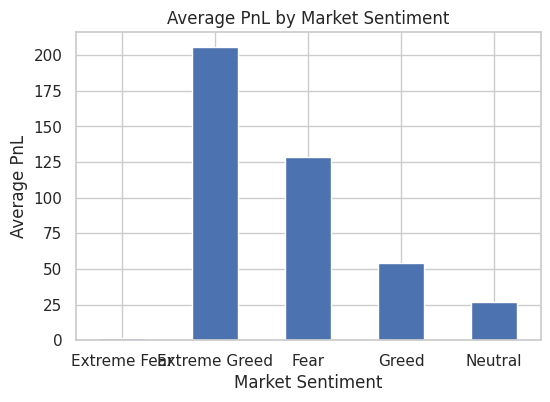

In [41]:
avg_pnl = merged_df.groupby('classification')['Closed PnL'].mean()

plt.figure(figsize=(6,4))
avg_pnl.plot(kind='bar')
plt.title('Average PnL by Market Sentiment')
plt.ylabel('Average PnL')
plt.xlabel('Market Sentiment')
plt.xticks(rotation=0)
plt.show()


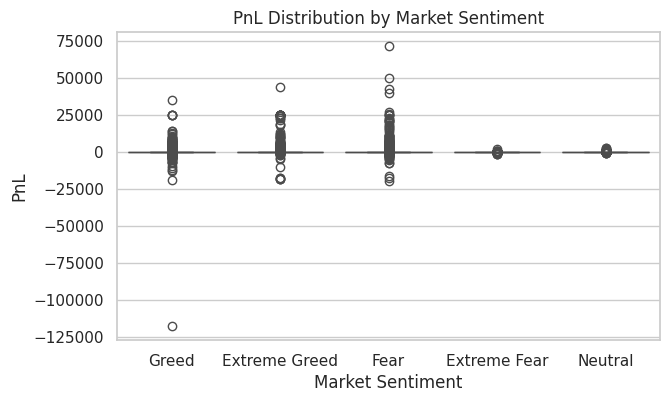

In [42]:
plt.figure(figsize=(7,4))
sns.boxplot(x='classification', y='Closed PnL', data=merged_df)
plt.title('PnL Distribution by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('PnL')
plt.show()


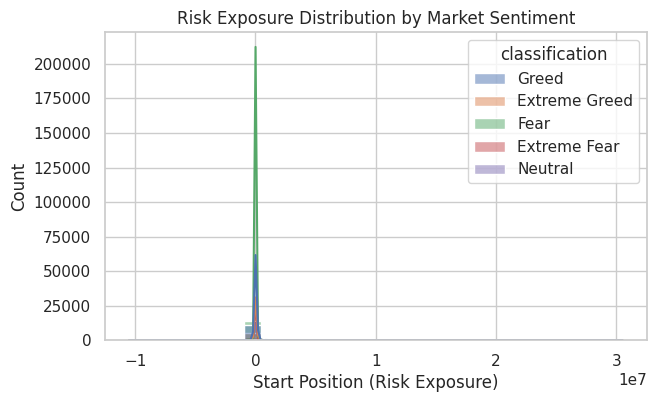

In [43]:
plt.figure(figsize=(7,4))
sns.histplot(
    data=merged_df,
    x='Start Position',
    hue='classification',
    bins=30,
    kde=True
)
plt.title('Risk Exposure Distribution by Market Sentiment')
plt.xlabel('Start Position (Risk Exposure)')
plt.show()


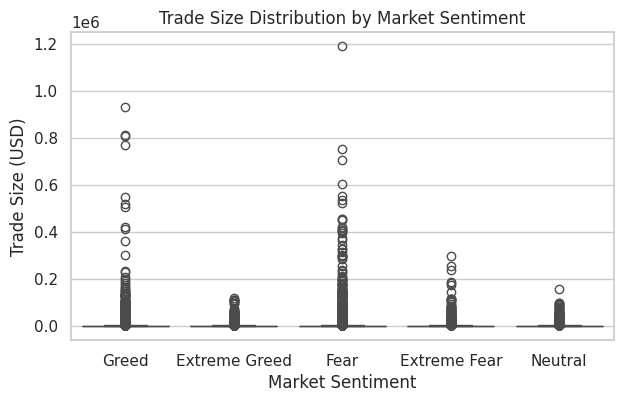

In [44]:
plt.figure(figsize=(7,4))
sns.boxplot(x='classification', y='Size USD', data=merged_df)
plt.title('Trade Size Distribution by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Trade Size (USD)')
plt.show()


### Visual Insights Summary
The visualizations reinforce statistical findings by highlighting differences in
profitability, risk exposure, and trade size between Fear and Greed market
conditions. Visual patterns make sentiment-driven behavior easier to interpret.


## Key Insights and Recommendations

- Greed-driven markets are associated with higher risk exposure and more extreme
  losses, despite occasional high profits.
- Fear markets exhibit more disciplined trading behavior and more consistent
  outcomes.
- Incorporating sentiment-aware risk controls can help mitigate downside risk
  during highly optimistic market phases.

### Conclusion
Market sentiment is a powerful behavioral indicator. Using it alongside
traditional trading metrics can lead to better-informed, risk-aware trading
strategies.
